# Algorithm for tracing how the guidewire moves

In [166]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter
%matplotlib inline

In [167]:
image1 = "guidewire_follow_testdata/1.jpg"
image2 = "guidewire_follow_testdata/2.jpg"
image3 = "guidewire_follow_testdata/3.jpg"
image4 = "guidewire_follow_testdata/4.jpg"
image1 = cv2.imread(image1, cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread(image2, cv2.IMREAD_GRAYSCALE)
image3 = cv2.imread(image3, cv2.IMREAD_GRAYSCALE)
image4 = cv2.imread(image4, cv2.IMREAD_GRAYSCALE)
images = [image1, image2, image3, image4]


In [168]:
def find_artifact_centroids(image, gaussian_kernel: int = 9):
        """
        Applies gaussian blur and thresholding to separate artifacts from noise.
        The center of gravity of each remaining blob is returned.
        """
        blurred = cv2.GaussianBlur(image, (gaussian_kernel, gaussian_kernel), 0)
        _, threshold = cv2.threshold(blurred, 200, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        threshold = cv2.cvtColor(threshold, cv2.COLOR_GRAY2RGB)
        centroids = None
        if len(contours) > 0:
            centroids = []
            for contour in contours:
                M = cv2.moments(contour)
                if M["m00"] != 0:
                    cX = int(M["m10"] / M["m00"])
                    cY = int(M["m01"] / M["m00"])
                    centroids.append((cX, cY))
                    cv2.circle(threshold, (cX, cY), 3, (0, 255, 0), -1)
        return centroids

In [169]:
class ArtifactTracker:
    """
    Did not manage to get any existing trackers to work, so why not just reinvent the wheel...
    """
    def __init__(self, initial_coordinate, max_range=30):
        self.max_range = max_range
        self.coordinates = initial_coordinate
        self.trajectory = [initial_coordinate]

    def update(self, new_coordinates):
        """
        Find the closest coordinate within max_range
        """
        closest_coordinate = None
        min_distance = float('inf')
        for coord in new_coordinates:
            dist = self.distance(coord)
            if dist < min_distance and dist <= self.max_range:
                closest_coordinate = coord
                min_distance = dist
        if closest_coordinate is not None:
            self.coordinates = closest_coordinate
            self.trajectory.append(closest_coordinate)
            
    def distance(self, coordinate):
        """
        Calculate the Euclidean distance between two coordinates.
        """
        return math.sqrt((coordinate[0] - self.coordinates[0])**2 + (coordinate[1] - self.coordinates[1])**2)
    
    

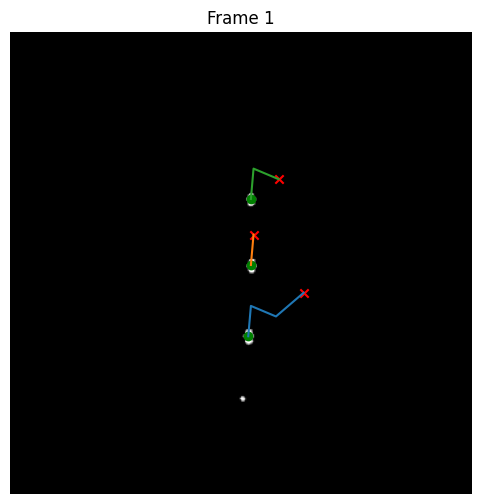

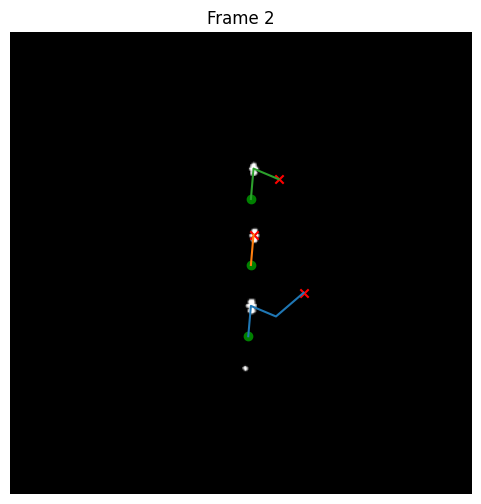

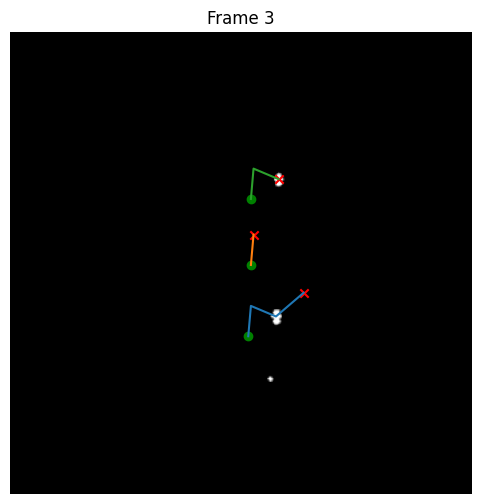

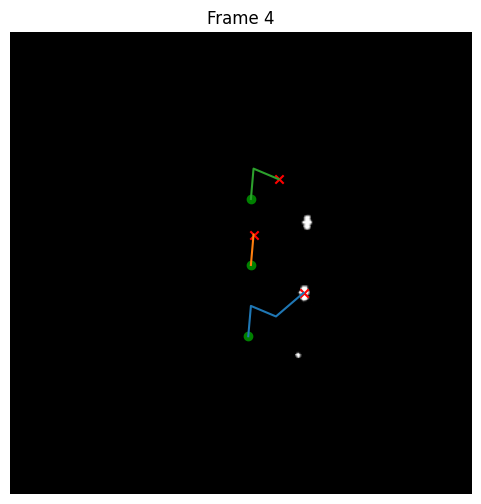

In [170]:
trackers = []
for image in images:
    centroids = find_artifact_centroids(image)
    if centroids is None:
        continue
    if not trackers:
        for centroid in centroids:
            trackers.append(ArtifactTracker(centroid))
    else:
        for tracker in trackers:
            tracker.update(centroids)
    
# Plotting
for i, image in enumerate(images):
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap='gray')
    for j, tracker in enumerate(trackers):
        trajectory = np.array(tracker.trajectory)
        plt.plot(trajectory[:, 0], trajectory[:, 1], label=f'Tracker {j+1}', color=plt.cm.tab10(j))
        plt.scatter(trajectory[0, 0], trajectory[0, 1], color='green', marker='o')  # Starting point
        plt.scatter(trajectory[-1, 0], trajectory[-1, 1], color='red', marker='x')   # Ending point
    plt.title(f'Frame {i+1}')
    plt.axis('off')
    plt.show()